Thanks to Sergii for this kernel:

https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481. 

I just changed Folds to 5 from 3 and number of iterations to 6000 from 1500. The lb improved to -1.643 from -1.481

## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
'{DATA_PATH}\\train.csv'

'{DATA_PATH}\\train.csv'

In [5]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [6]:
#imputed_train = pd.read_csv('../input/imputed/imputed_4_correlated_train.csv',dtype = train_dtypes)

#imputed_test = pd.read_csv('../input/imputed/imputed_4_correlated_test.csv',dtype = train_dtypes)
# imputed_test['molecule_index'] = imputed_test.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')

In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [23]:
#base0, structures0 = build_type_dataframes(train_csv, structures_csv, coupling_type)

## Check LightGBM with the smallest type

In [24]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43363, 73)
Wall time: 1.35 s


In [25]:
full.head(15)

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,19,7,2,54.063999,1.984051,-0.131759,0.386749,1.178267,-0.633243,0.056917,1,6,6,1,8,1,1,0,1.190494,-0.027404,0.006799,0.913903,-1.037220,-0.028261,-0.870809,NaN,-1.639196,-0.017521,1.499697,1.929238,-0.639807,1.785173,1.911242,NaN,0.100062,-0.148948,-0.025670,-0.461001,-0.407276,1.031491,-0.523452,NaN,1.004771,1.727509,1.006952,2.084700,1.369356,2.043309,2.596395,2.434870,3.357022,1.522602,2.472166,2.627629,3.622846,2.184789,3.164912,2.263603,2.493768,1.213961,2.853019,2.873019,3.752229,2.154795,3.626644,3.318123,4.152511,2.138156,NaN,NaN,NaN,NaN
6,229,19,8,2,56.186001,1.190494,-1.639196,0.100062,1.178267,-0.633243,0.056917,1,6,8,6,1,1,1,0,1.984051,-0.027404,-1.037220,0.006799,0.913903,-0.028261,-0.870809,NaN,-0.131759,-0.017521,-0.639807,1.499697,1.929238,1.785173,1.911242,NaN,0.386749,-0.148948,-0.407276,-0.025670,-0.461001,1.031491,-0.523452,NaN,1.006952,1.727509,1.004771,2.043309,1.369356,2.084700,2.493768,2.263603,3.164912,1.213961,3.357022,2.434870,2.596395,1.522602,3.622846,2.627629,2.472166,2.184789,3.752229,2.873019,2.853019,2.154795,4.152511,3.318123,3.626644,2.138156,NaN,NaN,NaN,NaN
7,389,32,4,0,37.719002,0.917298,1.835475,0.052027,-0.036081,1.487625,0.036781,1,6,1,1,6,7,0,0,-0.471622,-0.010395,0.528271,0.489462,-1.371810,-2.440267,NaN,NaN,1.856772,0.025176,-0.345333,-0.408804,-0.521089,-0.959564,NaN,NaN,-0.802756,-0.015066,0.864695,-0.897152,0.027393,0.033705,NaN,NaN,1.014969,1.631013,1.015277,2.035264,1.463593,2.046443,2.359597,2.088941,2.937592,1.096093,2.474020,2.178272,2.462809,1.102846,3.285424,2.412301,2.674642,1.46753

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [26]:
full.columns

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')

For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [27]:
df = take_n_atoms(full, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [28]:
df.head()

,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.688900
1,1,1,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.689098
2,1,1,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.690498
3,1,6,8,1,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,0.0,0.0,0.0,0.0,55.525200
4,1,6,1,8,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,0.0,0.0,0.0,0.0,54.735901


In [29]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 23), (8673, 23), (34690,), (8673,))

In [30]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [31]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.12484	valid_1's l1: 1.14424
[200]	training's l1: 0.922035	valid_1's l1: 0.945492
[300]	training's l1: 0.829251	valid_1's l1: 0.858007
[400]	training's l1: 0.773388	valid_1's l1: 0.80602
[500]	training's l1: 0.735149	valid_1's l1: 0.768969
[600]	training's l1: 0.702138	valid_1's l1: 0.738762
[700]	training's l1: 0.677151	valid_1's l1: 0.714933
[800]	training's l1: 0.656839	valid_1's l1: 0.697551
[900]	training's l1: 0.640711	valid_1's l1: 0.684394
[1000]	training's l1: 0.626157	valid_1's l1: 0.670661
[1100]	training's l1: 0.613323	valid_1's l1: 0.657888
[1200]	training's l1: 0.601107	valid_1's l1: 0.646809
[1300]	training's l1: 0.590771	valid_1's l1: 0.63805
[1400]	training's l1: 0.581802	valid_1's l1: 0.62983
[1500]	training's l1: 0.573225	valid_1's l1: 0.622875
[1600]	training's l1: 0.565175	valid_1's l1: 0.616407
[1700]	training's l1: 0.557706	valid_1's l1: 0.611032
[1800]	training's l1: 0.551211	va

-0.6836775684778407

Not a bad score for such a simple set of features.

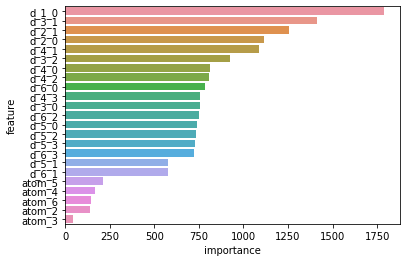

In [32]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model

In [33]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [34]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
        #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [35]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 5
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.12424	valid_1's l1: 1.1446
[200]	training's l1: 0.929061	valid_1's l1: 0.955209
[300]	training's l1: 0.834008	valid_1's l1: 0.864223
[400]	training's l1: 0.773036	valid_1's l1: 0.805616
[500]	training's l1: 0.731304	valid_1's l1: 0.767025
[600]	training's l1: 0.70014	valid_1's l1: 0.737649
Did not meet early stopping. Best iteration 

KeyboardInterrupt: 

Checking cross-validation scores for each type:

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## Room for improvement

There are many steps, how to improve the score for this kernel:
* Tune LGB hyperparameters - I did nothing for this
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries

Also, this representation fails badly on `*JHC` coupling types. The main reason for this is that 3rd and 4th atoms are usually located on the same distance and representation starts "jittering" randomly picking one of them. So, two similar configurations will have different representation due to usage of 3/4 of 4/3 distances.

The biggest challenge would be to implement handcrafted KNN with some compiled language(Rust, C++, C).

Would be cool to see this kernel forked and addressed some of the issues with higher LB score.